In [219]:
import numpy as np

import matplotlib.pyplot as plt
from h5py import File
%matplotlib inline

from jax import numpy as jnp
import jax

from numpyro.infer import MCMC, NUTS, util

import csiborgtools

%load_ext autoreload
%autoreload 2


paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [4]:
fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "A2", fpath, paths, ksmooth=None)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "A2", fpath, paths, ksmooth=1)

14:31:30: reading the catalogue.
14:31:30: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:102: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


14:31:31: calculating the radial velocity.


100%|██████████| 452/452 [00:00<00:00, 23479.46it/s]


14:31:31: reading the catalogue.
14:31:31: reading the interpolated field.


100%|██████████| 101/101 [00:22<00:00,  4.53it/s]


14:31:53: calculating the radial velocity.


100%|██████████| 452/452 [00:02<00:00, 171.48it/s]


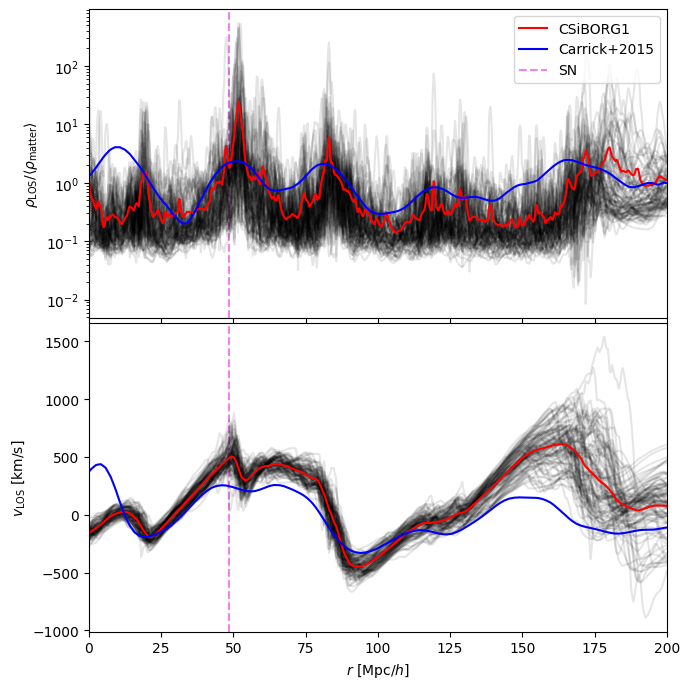

In [8]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]

k = 50
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
# Get rid of vertical spacing
fig.subplots_adjust(wspace=0)

# Plot CSiBORG
for i in range(101):
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

# Plot Carrick+2015
axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :], color="blue")


for i in range(2):
    label = "SN"
    rdist = loader_csiborg.cat["r_hMpc"][k]
    axs[i].axvline(rdist, color="violet", linestyle="--",
                zorder=0, label=label)

axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

axs[0].set_yscale("log")

axs[0].legend(loc="upper right")
axs[0].set_xlim(0, 200)

fig.tight_layout(w_pad=0, h_pad=0)
# fig.savefig(f"../plots/example_los.png", dpi=500, bbox_inches="tight")

fig.show()

## Test running a model

In [220]:
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
loader = csiborgtools.flow.DataLoader("Carrick2015", "A2", fpath_data, paths, ksmooth=0)
Omega_m = csiborgtools.simname2Omega_m("Carrick2015")

10:31:41: reading the catalogue.
10:31:41: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:102: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  simname, catalogue, ksmooth, paths)


10:31:41: calculating the radial velocity.


100%|██████████| 452/452 [00:00<00:00, 24805.05it/s]


In [221]:
los_overdensity = loader.los_density[:, 0, :]
los_velocity = loader.los_radial_velocity[:, 0, :]

# # PV calibration
# RA = loader.cat["RA"]
# dec = loader.cat["DEC"]
# zCMB = loader.cat["z_CMB"]

# mB = loader.cat["mB"]
# x1 = loader.cat["x1"]
# c = loader.cat["c"]

# e_mB = loader.cat["e_mB"]
# e_x1 = loader.cat["e_x1"]
# e_c = loader.cat["e_c"]

# PV no calibration
RA = loader.cat["RA"]
dec = loader.cat["DEC"]
z_obs = loader.cat["z_obs"]

r_hMpc = loader.cat["r_hMpc"]
e_r_hMpc = loader.cat["e_rhMpc"]

In [222]:
model = csiborgtools.flow.SD_PV_validation_model(los_overdensity, los_velocity, RA, dec, z_obs, r_hMpc, e_r_hMpc, loader.rdist, Omega_m)

# model_old = csiborgtools.flow.SN_PV_validation_model_old

In [223]:
true_samples = {'Vext_x': jnp.array(0.0, dtype=jnp.float32),
                'Vext_y': jnp.array(0.0, dtype=jnp.float32),
                'Vext_z': jnp.array(0.0, dtype=jnp.float32),
                'alpha': jnp.array(1, dtype=jnp.float32),
                'beta': jnp.array(1, dtype=jnp.float32),
                'sigma_v': jnp.array(112, dtype=jnp.float32),
                }

util.log_likelihood(model, true_samples)


{'ll': Array(-3291.0427, dtype=float32)}

In [228]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=500, chain_method="sequential")
rng_key = jax.random.PRNGKey(0)

In [229]:
mcmc.run(rng_key)

sample: 100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s, 3 steps of size 7.11e-01. acc. prob=0.88]


In [231]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    Vext_x    -62.10     18.47    -61.58    -97.45    -36.33    655.27      1.00
    Vext_y     24.97     27.82     24.77    -12.97     78.06    669.10      1.00
    Vext_z      3.54     25.23      2.67    -37.75     42.72    495.87      1.00
     alpha      1.64      0.21      1.65      1.29      1.98    473.75      1.00
      beta      0.83      0.06      0.84      0.73      0.94    542.08      1.00
   sigma_v    158.64     14.09    158.77    133.78    180.44    627.47      1.00

Number of divergences: 0


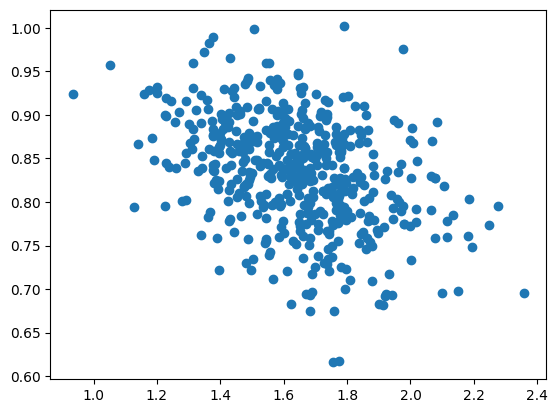

In [232]:
plt.figure()
plt.scatter(samples["alpha"], samples["beta"])
plt.show()

## Vizualize the results

In [49]:
with File("/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_A2_Carrick2015.hdf5", 'r') as f:
    beta = f["sim_0/Vext_z"][:]

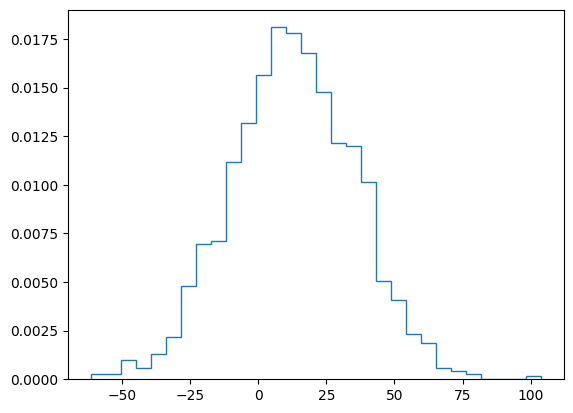

In [50]:
plt.figure()
plt.hist(beta, bins="auto", density=True, histtype="step")

plt.show()